# NUCLEI SEGMENTATION USING 2D UNET

UNet architecture :


![image](https://camo.githubusercontent.com/cf2ff198ddd4f4600726fa0f2844e77c4041186b/68747470733a2f2f686162726173746f726167652e6f72672f776562742f68752f6a692f69722f68756a696972767067706637657377713838685f783761686c69772e706e67)

Dataset I used **2018 Data Science Bowl** from kaggle,

[Link](https://www.kaggle.com/c/data-science-bowl-2018/data) to dataset .


In [5]:
import os
import numpy as np
import random
from tqdm import tqdm
import tensorflow as tf
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [6]:
# Defining paths
trainpath = '/content/stage1_train/'
testpath = '/content/stage1_test/'

In [7]:
# Getting all folder names
train_ids = next(os.walk(trainpath))[1]
test_ids = next(os.walk(testpath))[1]

In [8]:
# Constants for image
img_w = 128
img_h = 128
img_c = 3

In [9]:
# creating empty image lists 
X_train = np.zeros((len(train_ids), img_h, img_w, img_c), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), img_h, img_w, 1), dtype=np.bool)

In [10]:
# Looping over all folders and extracting data in test folder
for n, id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path = trainpath+id_
    img = imread(path+'/images/'+id_+'.png')[:,:,:img_c]
    img = resize(img,(img_h,img_w),mode='constant',preserve_range=True)
    X_train[n] = img
    mask = np.zeros((img_h,img_w,1),dtype=np.bool)
    for maskfile in next(os.walk(path+'/masks/'))[2]:
        mask_ = imread(path+'/masks/'+maskfile)
        mask_ = np.expand_dims(resize(mask_,(img_h,img_w),mode='constant',preserve_range=True),axis=-1)
        mask = np.maximum(mask,mask_)
    Y_train[n] = mask

100%|██████████| 670/670 [07:37<00:00,  1.46it/s]


In [11]:
# Preparing test data
X_test = np.zeros((len(test_ids),img_h,img_w,img_c),dtype=np.uint8)
size_test = []
for n,id_ in tqdm(enumerate(test_ids),total=len(test_ids)):
    path = testpath+id_
    img = imread(path+'/images/'+id_+'.png')[:,:,:img_c]
    size_test.append([img.shape[0],img.shape[1]])
    img = resize(img,(img_h,img_w),mode='constant',preserve_range=True)
    X_test[n] = img

100%|██████████| 65/65 [00:02<00:00, 29.53it/s]


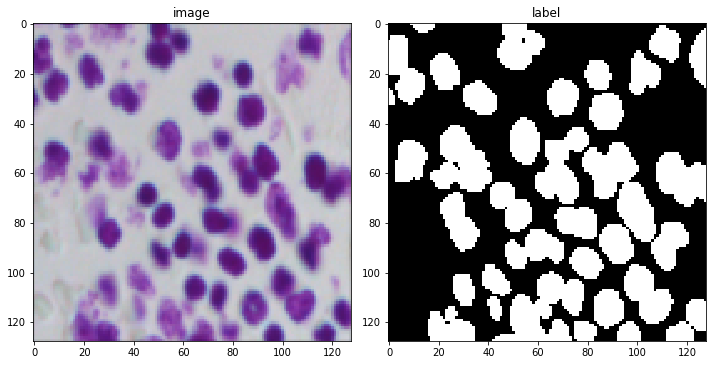

In [41]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1),imshow(X_train[0])
plt.title('image')
plt.subplot(1,2,2),imshow(np.squeeze(Y_train[0]))
plt.title('label')
plt.show()

In [23]:
import tensorflow as tf

#Build the model 2d UNet
inputs = tf.keras.layers.Input((img_h, img_w, img_c))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [24]:
# Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('nuclei_segmentation_model.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 2s 51ms/step - loss: 0.5652 - accuracy: 0.7956 - val_loss: 0.3630 - val_accuracy: 0.8212
Epoch 2/25
38/38 [==============================] - 1s 28ms/step - loss: 0.2781 - accuracy: 0.8650 - val_loss: 0.2118 - val_accuracy: 0.9166
Epoch 3/25
38/38 [==============================] - 1s 27ms/step - loss: 0.1716 - accuracy: 0.9332 - val_loss: 0.1575 - val_accuracy: 0.9395
Epoch 4/25
38/38 [==============================] - 1s 27ms/step - loss: 0.1347 - accuracy: 0.9481 - val_loss: 0.1505 - val_accuracy: 0.9461
Epoch 5/25
38/38 [==============================] - 1s 28ms/step - loss: 0.1160 - accuracy: 0.9558 - val_loss: 0.1310 - val_accuracy: 0.9552
Epoch 6/25
38/38 [==============================] - 1s 27ms/step - loss: 0.1062 - accuracy: 0.9595 - val_loss: 0.1213 - val_accuracy: 0.9559
Epoch 7/25
38/38 [==============================] - 1s 27ms/step - loss: 0.1122 - accuracy: 0.9566 - val_loss: 0.1324 - val_accuracy: 0.9517
Epoch 8/25
38

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


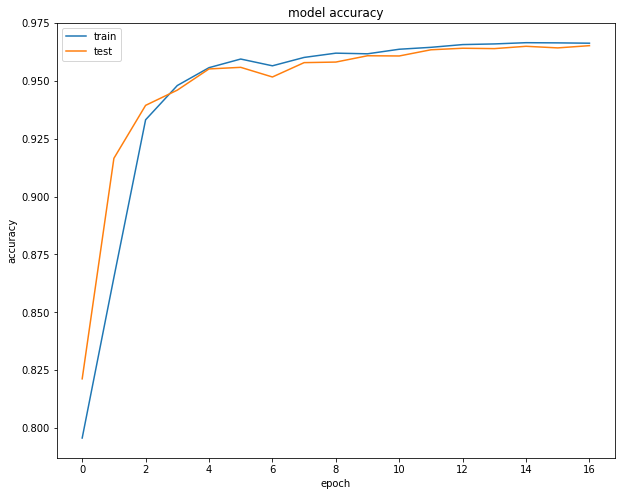

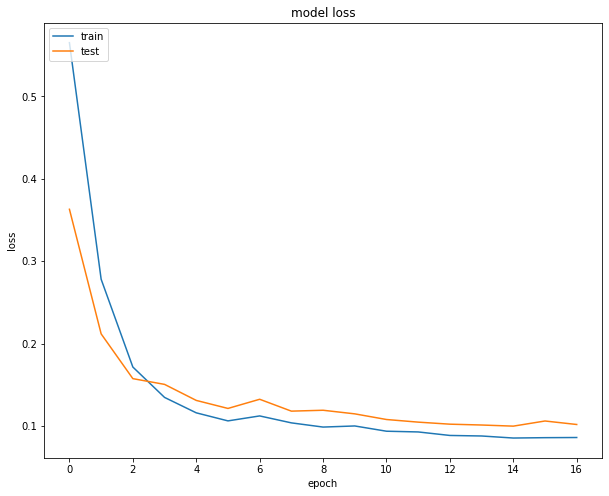

In [40]:
print(history.history.keys())
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
# testing
idx = random.randint(0, len(X_train))
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
train_pred = (preds_train > 0.5).astype(np.uint8)
val_pred = (preds_val > 0.5).astype(np.uint8)
test_pred = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 6ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


(<matplotlib.axes._subplots.AxesSubplot at 0x7fe2efc50dd8>,
 Text(0.5, 1.0, 'predictions'))

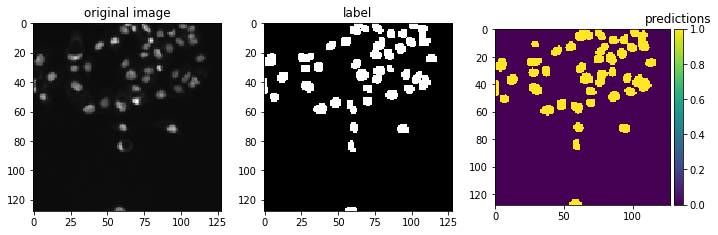

In [34]:
plt.figure(figsize=(10,8))
id = random.randint(0,len(train_pred))
plt.subplot(1,3,1),imshow(X_train[id]),plt.title('original image')
plt.subplot(1,3,2),imshow(np.squeeze(Y_train[id])),plt.title('label')
plt.subplot(1,3,3),imshow(np.squeeze(train_pred[id])),plt.title('predictions')

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


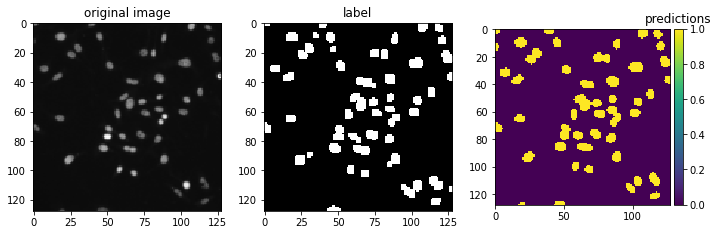

In [36]:
plt.figure(figsize=(10,8))
ix = random.randint(0, len(val_pred))
plt.subplot(1,3,1),imshow(X_train[int(X_train.shape[0]*0.9):][ix]),plt.title('original image')
plt.subplot(1,3,2),imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix])),plt.title('label')
plt.subplot(1,3,3),imshow(np.squeeze(val_pred[ix])),plt.title('predictions')
plt.show()